In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import pickle
import os
import yfinance as yf
import pandas_datareader as pdr

In [2]:
yf.pdr_override()
ust_index = yf.download('GOVT', start='2016-01-01', end='2022-12-17')
ust_index 

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,25.170000,25.219999,25.090000,25.120001,22.398941,270100
2016-01-05,25.100000,25.129999,25.070000,25.090000,22.372190,272200
2016-01-06,25.180000,25.260000,25.150000,25.190001,22.461363,374000
2016-01-07,25.209999,25.250000,25.150000,25.240000,22.505943,189200
2016-01-08,25.230000,25.290001,25.200001,25.270000,22.532686,2518500
...,...,...,...,...,...,...
2022-12-12,23.180000,23.200001,23.059999,23.080000,23.043285,7923900
2022-12-13,23.330000,23.350000,23.209999,23.230000,23.193047,14265300
2022-12-14,23.250000,23.290001,23.170000,23.260000,23.223000,9833800


In [3]:
ust_index.loc[:, 'return'] = np.log(ust_index.Close/ust_index.Close.shift(1))
ust_index.loc[:, 'cumreturn'] = ust_index.loc[:, 'return'].cumsum().apply(np.exp)
ust_index.loc[:, 'cumreturn'].fillna(1, inplace=True)
ust_index

,Open,High,Low,Close,Adj Close,Volume,return,cumreturn
Date,,,,,,,,
2016-01-04,25.170000,25.219999,25.090000,25.120001,22.398941,270100,NaN,1.000000
2016-01-05,25.100000,25.129999,25.070000,25.090000,22.372190,272200,-0.001195,0.998806
2016-01-06,25.180000,25.260000,25.150000,25.190001,22.461363,374000,0.003978,1.002787
2016-01-07,25.209999,25.250000,25.150000,25.240000,22.505943,189200,0.001983,1.004777
2016-01-08,25.230000,25.290001,25.200001,25.270000,22.532686,2518500,0.001188,1.005971
...,...,...,...,...,...,...,...,...
2022-12-12,23.180000,23.200001,23.059999,23.080000,23.043285,7923900,-0.000866,0.918790
2022-12-13,23.330000,23.350000,23.209999,23.230000,23.193047,14265300,0.006478,0.924761
2022-12-14,23.250000,23.290001,23.170000,23.260000,23.223000,9833800,0.001291,0.925955


In [84]:
ust_index.loc[ust_index.index < '2021-01-01', :]

,Open,High,Low,Close,Adj Close,Volume,return,cumreturn
Date,,,,,,,,
2016-01-04,25.170000,25.219999,25.090000,25.120001,22.398941,270100,NaN,1.000000
2016-01-05,25.100000,25.129999,25.070000,25.090000,22.372190,272200,-0.001195,0.998806
2016-01-06,25.180000,25.260000,25.150000,25.190001,22.461363,374000,0.003978,1.002787
2016-01-07,25.209999,25.250000,25.150000,25.240000,22.505943,189200,0.001983,1.004777
2016-01-08,25.230000,25.290001,25.200001,25.270000,22.532686,2518500,0.001188,1.005971
...,...,...,...,...,...,...,...,...
2020-12-24,27.330000,27.360001,27.330000,27.340000,26.623739,1923000,0.000366,1.088376
2020-12-28,27.309999,27.360001,27.290001,27.350000,26.633482,3489600,0.000366,1.088774
2020-12-29,27.309999,27.360001,27.309999,27.350000,26.633482,4165600,0.000000,1.088774


In [11]:
sp500 = yf.download('SPY', start='2005-01-04', end='2022-12-17')
sp500 = sp500.loc[:, ['Close']]
sp500.loc[:, 'inv_wealth'] = sp500.Close.shift(1).ewm(span=180).mean()/sp500.Close
sp500

[*********************100%***********************]  1 of 1 completed


,Close,inv_wealth
Date,,
2005-01-04,118.830002,NaN
2005-01-05,118.010002,1.006949
2005-01-06,118.610001,0.998379
2005-01-07,118.440002,1.000359
2005-01-10,119.000000,0.995561
...,...,...
2022-12-12,398.950012,1.001570
2022-12-13,401.970001,0.994028
2022-12-14,399.399994,1.000491


In [10]:
spot_rates = pd.read_csv(f'{os.path.dirname(os.getcwd())}/spot rates.csv', header=0, index_col=0, parse_dates=[0])
spot_rates

,1 Mo,3 Mo,6 Mo,1 Yr,1.5 Yr,2 Yr,2.5 Yr,3 Yr,3.5 Yr,4 Yr,...,15.5 Yr,16 Yr,16.5 Yr,17 Yr,17.5 Yr,18 Yr,18.5 Yr,19 Yr,19.5 Yr,20 Yr
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-04,2.005,2.254500,2.63,2.841363,3.027602,3.233587,3.326710,3.420809,3.498336,3.606612,...,4.842699,4.885567,4.929747,4.975366,5.022561,5.071480,5.122285,5.175149,5.230262,5.287831
2005-01-05,1.974,2.296528,2.63,2.851581,3.050715,3.254094,3.343259,3.430722,3.488118,3.611481,...,4.928161,4.994564,5.057404,5.114665,5.164196,5.203726,5.230884,5.243241,5.238368,5.213911
2005-01-06,2.005,2.320000,2.63,2.841363,3.030181,3.212694,3.304574,3.400045,3.450037,3.583565,...,4.872529,4.935069,4.995920,5.053545,5.106303,5.152446,5.190127,5.217417,5.232331,5.232870
2005-01-07,2.005,2.330000,2.63,2.841363,3.034050,3.233510,3.334549,3.441946,3.505610,3.622425,...,4.868598,4.931184,4.992077,5.049745,5.102545,5.148734,5.186466,5.213815,5.228798,5.229417
2005-01-10,2.015,2.330000,2.67,2.881956,3.073422,3.263835,3.359675,3.451173,3.507568,3.629274,...,4.889944,4.952733,5.012630,5.067843,5.116460,5.156461,5.185729,5.202085,5.203324,5.187282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-12,3.728,4.245000,4.78,4.806720,4.614259,4.429216,4.280718,4.123517,4.079583,3.960123,...,3.803924,3.816281,3.828301,3.840133,3.851928,3.863844,3.876040,3.888682,3.901942,3.915996
2022-12-13,3.778,4.249734,4.70,4.693752,4.482063,4.254096,4.114267,3.981635,3.905424,3.824444,...,3.734331,3.789045,3.839170,3.881893,3.914267,3.933254,3.935774,3.918796,3.879438,3.815107
2022-12-14,3.772,4.263989,4.68,4.693984,4.478295,4.264775,4.116872,3.960233,3.908401,3.802997,...,3.656525,3.685458,3.713845,3.740942,3.765976,3.788139,3.806595,3.820483,3.828919,3.831005


In [12]:
real_par_rates = pd.read_csv(f'{os.path.dirname(os.getcwd())}/real par rates.csv', header=0, index_col=0, parse_dates=[0]).iloc[1:, :]
real_par_rates

,5 YR,7 YR,10 YR,20 YR
Date,,,,
2005-01-04,1.10,1.40,1.78,2.02
2005-01-05,1.13,1.42,1.79,2.04
2005-01-06,1.12,1.41,1.76,2.03
2005-01-07,1.16,1.45,1.80,2.06
2005-01-10,1.13,1.42,1.77,2.05
...,...,...,...,...
2022-12-12,1.45,1.38,1.33,1.29
2022-12-13,1.35,1.30,1.27,1.28
2022-12-14,1.39,1.34,1.30,1.32


In [15]:
fed_rates = pd.read_csv(f'{os.path.dirname(os.getcwd())}/US fed rates.csv', header=0, index_col=0, parse_dates=[0])
fed_rates.index.name = 'Date'
fed_rates

,DFF
Date,
2005-01-04,2.25
2005-01-05,2.25
2005-01-06,2.25
2005-01-07,2.24
2005-01-08,2.24
...,...
2022-12-12,3.83
2022-12-13,3.83
2022-12-14,3.83


In [17]:
lag = 100
period = 30

data = spot_rates.merge(sp500, on='Date', how='inner')
data = data.merge(real_par_rates, on='Date', how='inner')
data = data.merge(fed_rates, on='Date', how='inner')
data.rename(columns={'5 YR': 'real 5 yr par',
                    '7 YR': 'real 7 yr par',
                    '10 YR': 'real 10 yr par',
                    '20 YR': 'real 20 yr par',
                    'DFF': 'EFFR'}, inplace=True)

data.loc[:, '3M-5Y spread'] = data['5 Yr'] - data['3 Mo']
data.loc[:, '5Y-7Y spread'] = data['7 Yr'] - data['5 Yr']
data.loc[:, '7Y-10Y spread'] = data['10 Yr'] - data['7 Yr']
data.loc[:, '10Y-20Y spread'] = data['20 Yr'] - data['10 Yr']

data.loc[:, 'momentum'] = np.where(data['20 Yr']-data['20 Yr'].rolling(180).mean() < -0.05, 1, 0)
data.loc[:, 'momentum'] = np.where(data['20 Yr']-data['20 Yr'].rolling(180).mean() > 0.05, -1, data.momentum)


indicators = ['1 Mo', '20 Yr', '3M-5Y spread', '5Y-7Y spread', '7Y-10Y spread', '10Y-20Y spread', 'momentum',
             'inv_wealth', 'real 5 yr par', 'real 7 yr par', 'real 10 yr par', 'real 20 yr par', 'EFFR']

lagged_indicators = []
for indicator in indicators:
    lagged_indicators.append(indicator)
    for i in range(1, lag):
        data.loc[:, f'{indicator}_{i}'] = data.loc[:, indicator].shift(i)
        lagged_indicators.append(f'{indicator}_{i}')
        
# 0 for QE, 1 for QT
data.loc[((data.index >= '2007-08-17') & (data.index < '2015-12-16')) |
        ((data.index >= '2019-07-31') & (data.index < '2022-03-17')), 'fed regime'] = 0

data.loc[(data.index < '2007-08-17') | 
         ((data.index >= '2015-12-16') & (data.index < '2019-07-31')) | 
         (data.index >= '2022-03-17'), 'fed regime'] = 1
            
train = data.loc[(data.index >= '2005-07-01') & (data.index < '2016-01-01'), :]
test = data.loc[data.index >= '2016-01-01', :]

dfs = [train, test]
for df in dfs:
    df.loc[:, '20 Yr shifted'] = df['20 Yr'].shift(-period+1)
    df.loc[:, '20 Yr MTM PnL'] = (np.power((1+df['20 Yr']/100)/(1+df['20 Yr shifted']/100), 20) - 1).shift(-1)
    df.loc[:, 'signal'] = np.where(df['20 Yr MTM PnL'] > 0, 1, 0)
    df.loc[:, 'signal'] = np.where(df['20 Yr MTM PnL'] < 0, -1, df['signal'])
    
    df = df.loc[:, lagged_indicators + ['fed regime', '20 Yr shifted', '20 Yr MTM PnL', 'signal']]
    
train

C:\Users\kmlee\AppData\Local\Temp\ipykernel_25932\2236653661.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, f'{indicator}_{i}'] = data.loc[:, indicator].shift(i)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_25932\2236653661.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, f'{indicator}_{i}'] = data.loc[:, indicator].shift(i)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_25932\2236653661.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

C:\Users\kmlee\AppData\Local\Temp\ipykernel_25932\2236653661.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, f'{indicator}_{i}'] = data.loc[:, indicator].shift(i)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_25932\2236653661.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, f'{indicator}_{i}'] = data.loc[:, indicator].shift(i)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_25932\2236653661.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

C:\Users\kmlee\AppData\Local\Temp\ipykernel_25932\2236653661.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, f'{indicator}_{i}'] = data.loc[:, indicator].shift(i)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_25932\2236653661.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, f'{indicator}_{i}'] = data.loc[:, indicator].shift(i)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_25932\2236653661.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

C:\Users\kmlee\AppData\Local\Temp\ipykernel_25932\2236653661.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, f'{indicator}_{i}'] = data.loc[:, indicator].shift(i)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_25932\2236653661.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, f'{indicator}_{i}'] = data.loc[:, indicator].shift(i)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_25932\2236653661.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

C:\Users\kmlee\AppData\Local\Temp\ipykernel_25932\2236653661.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, f'{indicator}_{i}'] = data.loc[:, indicator].shift(i)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_25932\2236653661.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, f'{indicator}_{i}'] = data.loc[:, indicator].shift(i)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_25932\2236653661.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

,1 Mo,3 Mo,6 Mo,1 Yr,1.5 Yr,2 Yr,2.5 Yr,3 Yr,3.5 Yr,4 Yr,...,EFFR_94,EFFR_95,EFFR_96,EFFR_97,EFFR_98,EFFR_99,fed regime,20 Yr shifted,20 Yr MTM PnL,signal
Date,,,,,,,,,,,,,,,,,,,,,
2005-07-01,2.992,3.120568,3.38,3.542213,3.666151,3.801631,3.805671,3.810146,3.839526,3.841206,...,2.48,2.53,2.51,2.50,2.51,2.50,1.0,4.673146,-0.011493,-1
2005-07-05,3.001,3.140000,3.43,3.582852,3.708158,3.831892,3.843944,3.861792,3.883670,3.901031,...,2.50,2.48,2.53,2.51,2.50,2.51,1.0,4.674937,-0.012493,-1
2005-07-06,2.991,3.136884,3.41,3.562488,3.686474,3.811498,3.826199,3.841351,3.848705,3.878103,...,2.51,2.50,2.48,2.53,2.51,2.50,1.0,4.638067,-0.026016,-1
2005-07-07,2.970,3.130000,3.37,3.511498,3.631568,3.749994,3.768727,3.790574,3.791149,3.827356,...,2.57,2.51,2.50,2.48,2.53,2.51,1.0,4.679021,-0.008613,-1
2005-07-08,2.971,3.120148,3.39,3.552394,3.682830,3.822245,3.842139,3.862543,3.888713,3.901527,...,2.53,2.57,2.51,2.50,2.48,2.53,1.0,4.637770,-0.004666,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-24,0.145,0.237500,0.49,0.641266,0.833988,1.035147,1.188849,1.340815,1.408307,1.551667,...,0.14,0.14,0.14,0.14,0.14,0.14,1.0,NaN,NaN,0
2015-12-28,0.114,0.227500,0.51,0.661339,0.857883,1.055285,1.200085,1.340511,1.404157,1.546216,...,0.15,0.14,0.14,0.14,0.14,0.14,1.0,NaN,NaN,0
2015-12-29,0.125,0.231546,0.50,0.671409,0.879331,1.095826,1.241951,1.391448,1.466731,1.605014,...,0.15,0.15,0.14,0.14,0.14,0.14,1.0,NaN,NaN,0


In [85]:
def plot_validation_curve(data, regime):
    temp = data.loc[data['fed regime']==regime, :]
    temp = temp.iloc[:-period, :]
    trainx, trainy = temp.loc[:, lagged_indicators], temp.loc[:, ['signal']]

    params = {'max_depth': [i for i in range(0, 30, 5)],
      'max_features': ['sqrt', 'auto'],
      'min_samples_leaf': [i for i in range(0, 30, 5)],
      'n_estimators': [i for i in range(0, 30, 5)],
     'min_samples_split':[i for i in range(0, 30, 5)]} 

    scores = {}

    for param_name, param_range in params.items():
        train_score, test_score = validation_curve(RandomForestClassifier(),
                                                    trainx,
                                                    trainy,
                                                    param_name=param_name,
                                                    param_range=param_range,
                                                    scoring='accuracy',
                                                    n_jobs=-1)
        scores[param_name] = (train_score, test_score)
        
    fig, ax = plt.subplots(5, 1, figsize=(20,12))
    plt.tight_layout()
    counter = 0
    for param_name, val_scores in scores.items():
        ax[counter].plot(params[param_name], np.mean(val_scores[0], axis=1), label='train score')
        ax[counter].plot(params[param_name], np.mean(val_scores[1], axis=1), label='val score')
        ax[counter].legend()
        ax[counter].set_title(param_name)
        counter += 1

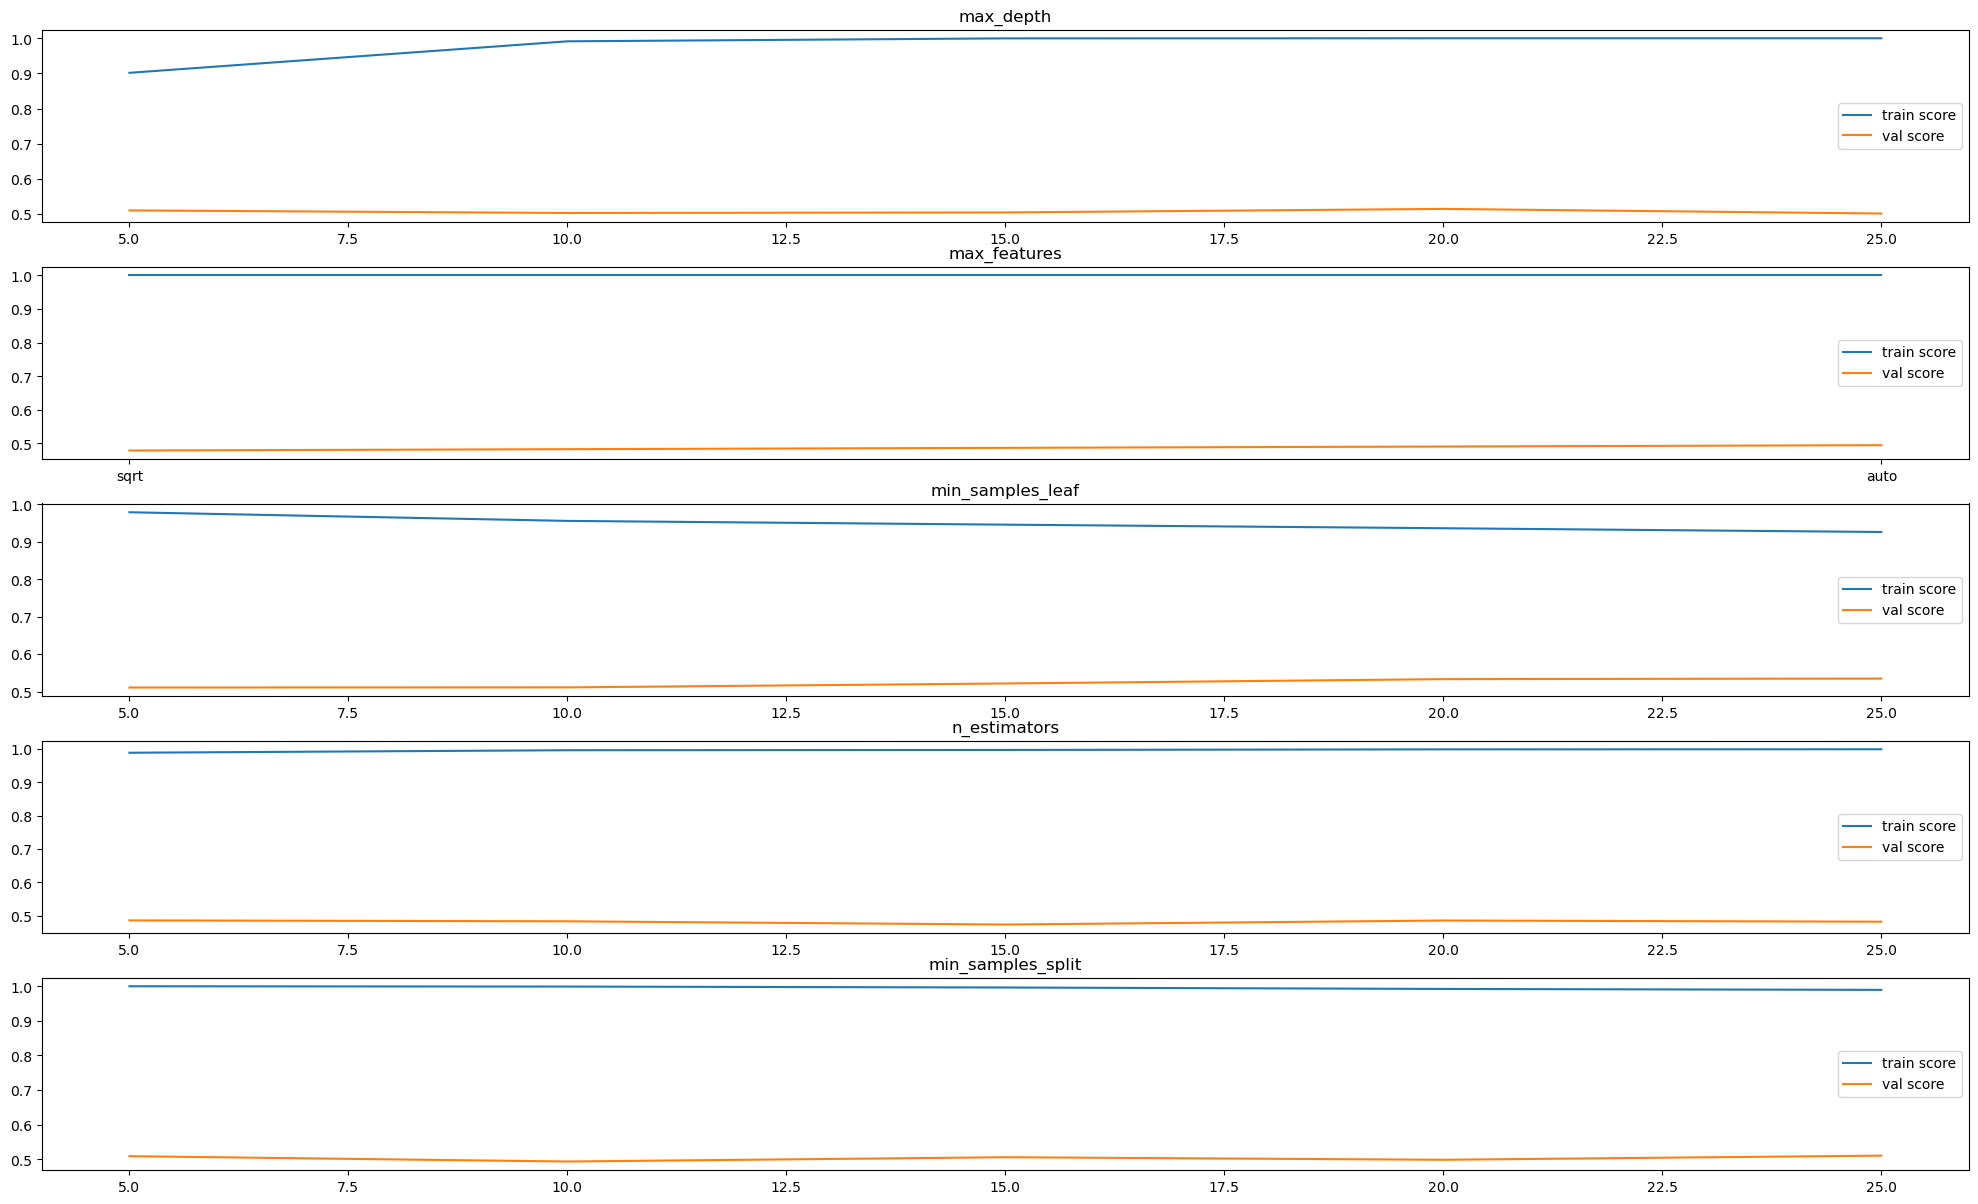

In [86]:
plot_validation_curve(train, 0)

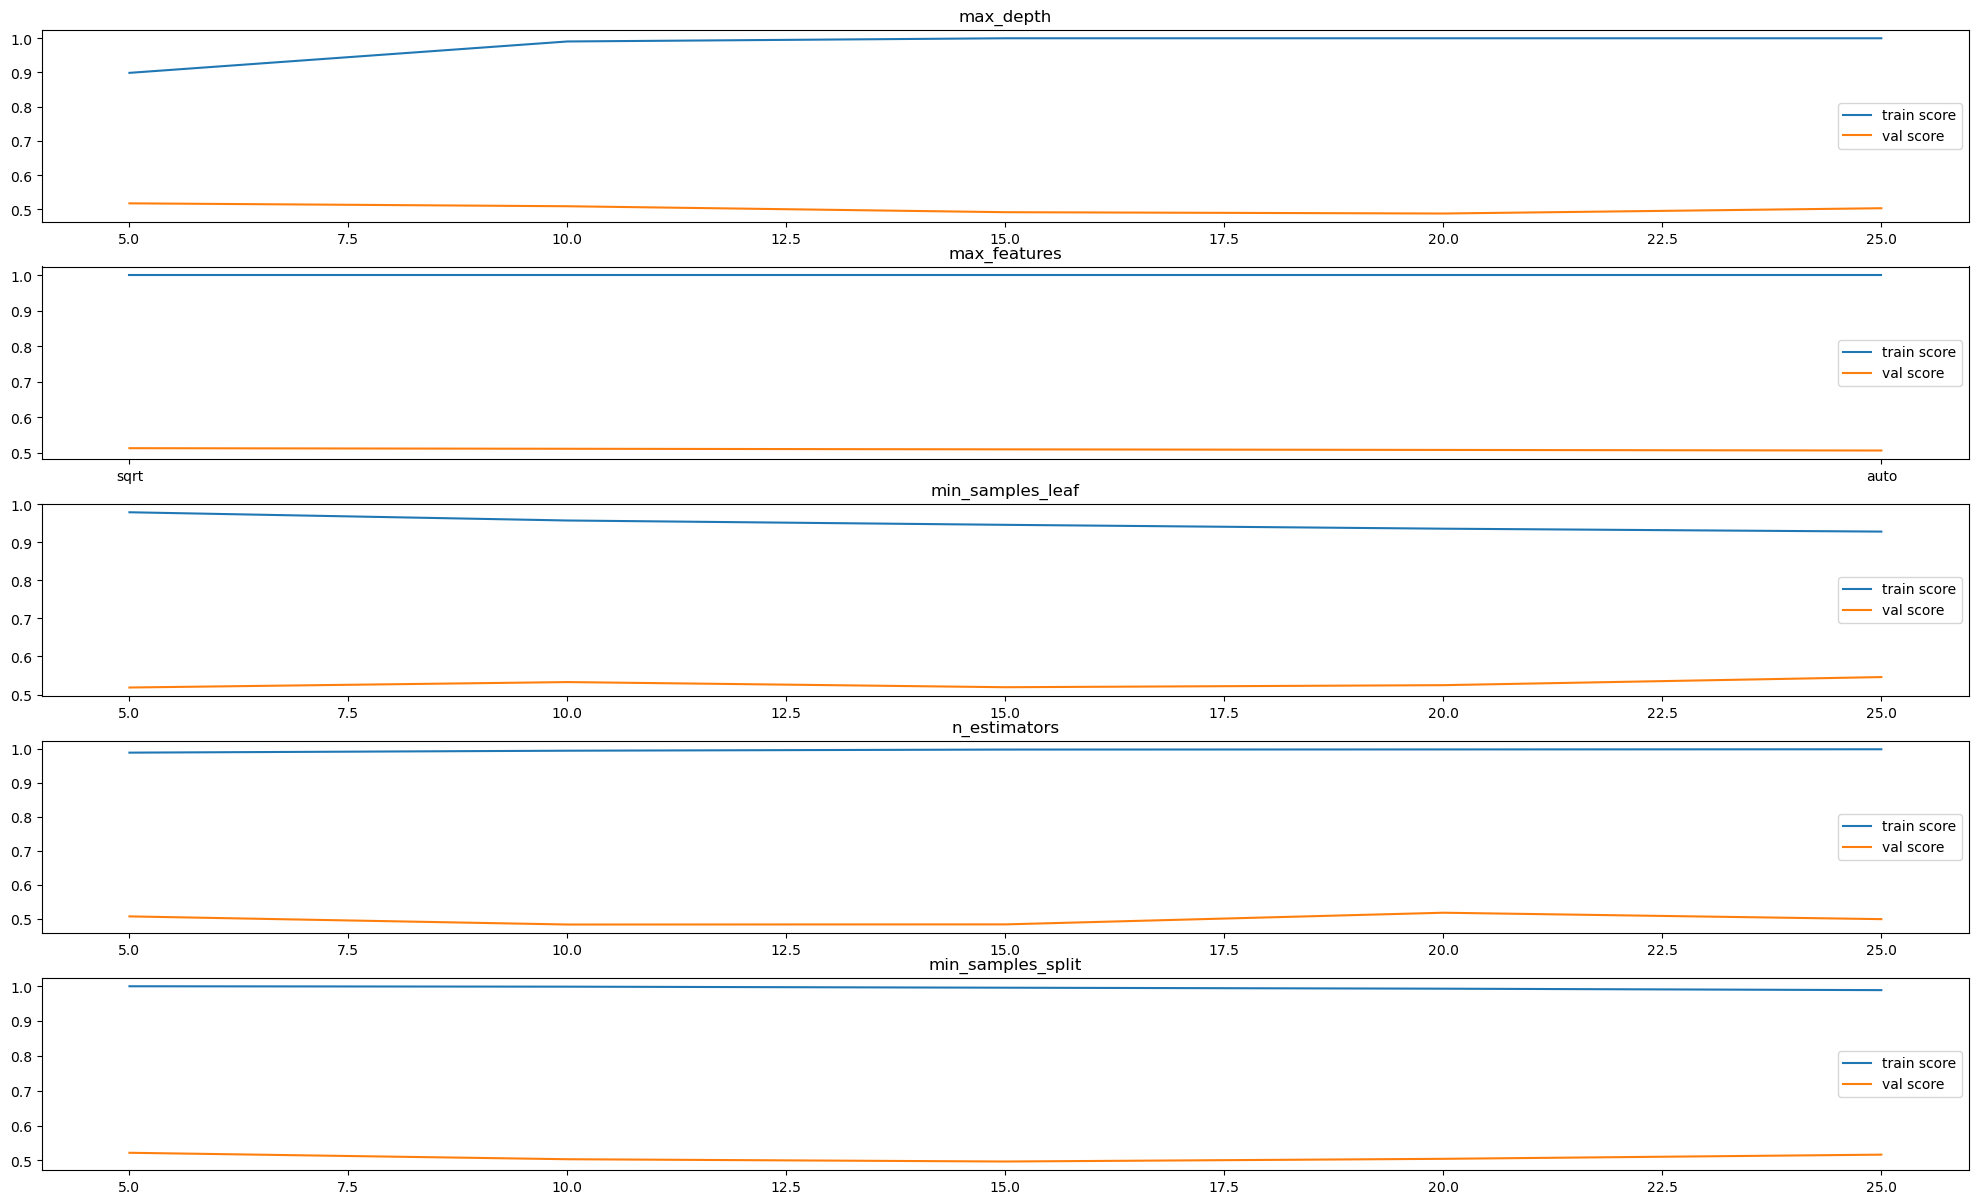

In [87]:
plot_validation_curve(train, 1)

In [88]:
# Train QE model
temp = train.loc[train['fed regime']==0, :]
temp = temp.iloc[:-period, :]
trainx, trainy = temp.loc[:, lagged_indicators], temp.loc[:, ['signal']]

params = {'max_depth': [i for i in range(15, 20)],
  'max_features': ['sqrt', 'auto'],
  'min_samples_leaf': [i for i in range(20, 30)],
  'n_estimators': [i for i in range(20, 25)],
 'min_samples_split':[i for i in range(20, 30)]} 

rf = RandomForestClassifier()

# Cross validation using TimeSeriesSplit
time_series_split = TimeSeriesSplit(n_splits=3)

rf_cv = GridSearchCV(rf, params, cv=time_series_split, n_jobs=-1, verbose=20)

#Fit the random forest with our X_train and Y_train
rf_cv.fit(trainx, trainy)

#Save the fited variable into a Pickle file
file_loc = 'UST_RF_model_QE.pkl'
with open(file_loc, 'wb') as f:
    pickle.dump(rf_cv, f)

Fitting 3 folds for each of 5000 candidates, totalling 15000 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [89]:
# Train QT model
temp = train.loc[train['fed regime']==1, :]
temp = temp.iloc[:-period, :]
trainx, trainy = temp.loc[:, lagged_indicators], temp.loc[:, ['signal']]

params = {'max_depth': [i for i in range(5, 10)],
  'max_features': ['sqrt', 'auto'],
  'min_samples_leaf': [i for i in range(8, 12)],
  'n_estimators': [i for i in range(18, 22)],
 'min_samples_split':[i for i in range(5, 10)]} 

rf = RandomForestClassifier()

# Cross validation using TimeSeriesSplit
time_series_split = TimeSeriesSplit(n_splits=3)

rf_cv = GridSearchCV(rf, params, cv=time_series_split, n_jobs=-1, verbose=20)

#Fit the random forest with our X_train and Y_train
rf_cv.fit(trainx, trainy)

#Save the fited variable into a Pickle file
file_loc = 'UST_RF_model_QT.pkl'
with open(file_loc, 'wb') as f:
    pickle.dump(rf_cv, f)

Fitting 3 folds for each of 800 candidates, totalling 2400 fits


C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [90]:
probs = []
positions = []

with open('UST_RF_model_QE.pkl', 'rb') as f:
    QE_model = pickle.load(f).best_estimator_
    
with open('UST_RF_model_QT.pkl', 'rb') as f:
    QT_model = pickle.load(f).best_estimator_

for i in range(len(test.index)):
    temp = test.loc[test.index == test.index[i], :]
    tempx = temp.loc[:, lagged_indicators]
    if i%period == 0:
        if temp.iloc[0]['fed regime'] == 0:
            model = QE_model
        else:
            model = QT_model
        pred_prob = model.predict_proba(tempx)
        prob = np.max(pred_prob)
        position = -1 if np.argmax(pred_prob) == 0 else 1
    else:
        prob = 0
        position = 0
    probs.append(prob)
    positions.append(position)

In [91]:
def strategy_return(test_df, probs, positions):
    temp = test_df.loc[:, ['1 Mo', '20 Yr', '20 Yr shifted', '20 Yr MTM PnL', 'signal']]
    temp.loc[:, '20Y allocation'] = probs
    temp.loc[:, '1M allocation'] = 1 - np.array(probs)
    temp.loc[:, 'position'] = positions
    for i in range(len(test_df)):
        date = temp.index[i]
        if i%period == 0:
            temp.loc[temp.index==date, 'return'] = temp.loc[temp.index==date, '1 Mo']/1200*temp.loc[temp.index==date, '1M allocation'] + temp.loc[temp.index==date, '20 Yr MTM PnL']*temp.loc[temp.index==date, '20Y allocation']*temp.loc[temp.index==date, 'position'] + 1
        else:
            temp.loc[temp.index==date, 'return'] = 1
    temp.loc[:, 'return'] = temp['return'].shift(period).fillna(1)
    temp.loc[:, 'strategy'] = np.log(temp['return'])
    temp.loc[:, 'cumstrategy'] = temp.strategy.cumsum().apply(np.exp)
    return temp

In [92]:
strategies = strategy_return(test, probs, positions)
strategies

,1 Mo,20 Yr,20 Yr shifted,20 Yr MTM PnL,signal,20Y allocation,1M allocation,position,return,strategy,cumstrategy
Date,,,,,,,,,,,
2016-01-04,0.170,2.755316,2.285675,0.092256,1,0.676036,0.323964,-1,1.0,0.0,1.000000
2016-01-05,0.201,2.797437,2.344866,0.089735,1,0.000000,1.000000,0,1.0,0.0,1.000000
2016-01-06,0.210,2.701454,2.261123,0.083346,1,0.000000,1.000000,0,1.0,0.0,1.000000
2016-01-07,0.195,2.670793,2.260654,0.080581,1,0.000000,1.000000,0,1.0,0.0,1.000000
2016-01-08,0.195,2.670142,2.273071,0.093426,1,0.000000,1.000000,0,1.0,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-12,3.728,3.915996,NaN,NaN,0,0.000000,1.000000,0,1.0,0.0,1.031104
2022-12-13,3.778,3.815107,NaN,NaN,0,0.000000,1.000000,0,1.0,0.0,1.031104
2022-12-14,3.772,3.831005,NaN,NaN,0,0.000000,1.000000,0,1.0,0.0,1.031104


In [93]:
strategies.loc[strategies.index < '2021-01-01', :]

,1 Mo,20 Yr,20 Yr shifted,20 Yr MTM PnL,signal,20Y allocation,1M allocation,position,return,strategy,cumstrategy
Date,,,,,,,,,,,
2016-01-04,0.170,2.755316,2.285675,0.092256,1,0.676036,0.323964,-1,1.0,0.0,1.000000
2016-01-05,0.201,2.797437,2.344866,0.089735,1,0.000000,1.000000,0,1.0,0.0,1.000000
2016-01-06,0.210,2.701454,2.261123,0.083346,1,0.000000,1.000000,0,1.0,0.0,1.000000
2016-01-07,0.195,2.670793,2.260654,0.080581,1,0.000000,1.000000,0,1.0,0.0,1.000000
2016-01-08,0.195,2.670142,2.273071,0.093426,1,0.000000,1.000000,0,1.0,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.079,1.526996,1.878617,-0.067179,-1,0.000000,1.000000,0,1.0,0.0,0.792159
2020-12-28,0.086,1.528617,1.882257,-0.058559,-1,0.000000,1.000000,0,1.0,0.0,0.792159
2020-12-29,0.082,1.541217,1.848046,-0.065436,-1,0.000000,1.000000,0,1.0,0.0,0.792159


In [94]:
hits = []
for i in range(len(strategies.loc[strategies.index < '2021-01-01', :].index)):
    if i%period==0:
        hits.append(1 if strategies.loc[strategies.index < '2021-01-01', :].iloc[i]['position'] == strategies.loc[strategies.index < '2021-01-01', :].iloc[i]['signal'] else 0)
np.array(hits).mean()*100

50.0

In [95]:
hits = []
for i in range(len(strategies.index)):
    if i%period==0:
        hits.append(1 if strategies.iloc[i]['position'] == strategies.iloc[i]['signal'] else 0)
np.array(hits).mean()*100

53.44827586206896

In [96]:
def plot_returns(benchmark, strategy, title):
    plt.figure(figsize=(20, 12))
    plt.plot(pd.to_datetime(strategy.index).date, strategy.cumstrategy, label='Model')
    plt.plot(benchmark.index, benchmark['cumreturn'], color='red', label='iShares UST Bond ETF Buy & Hold')
    plt.title(title)
    plt.gca().grid(True)
    plt.legend(loc='upper left')

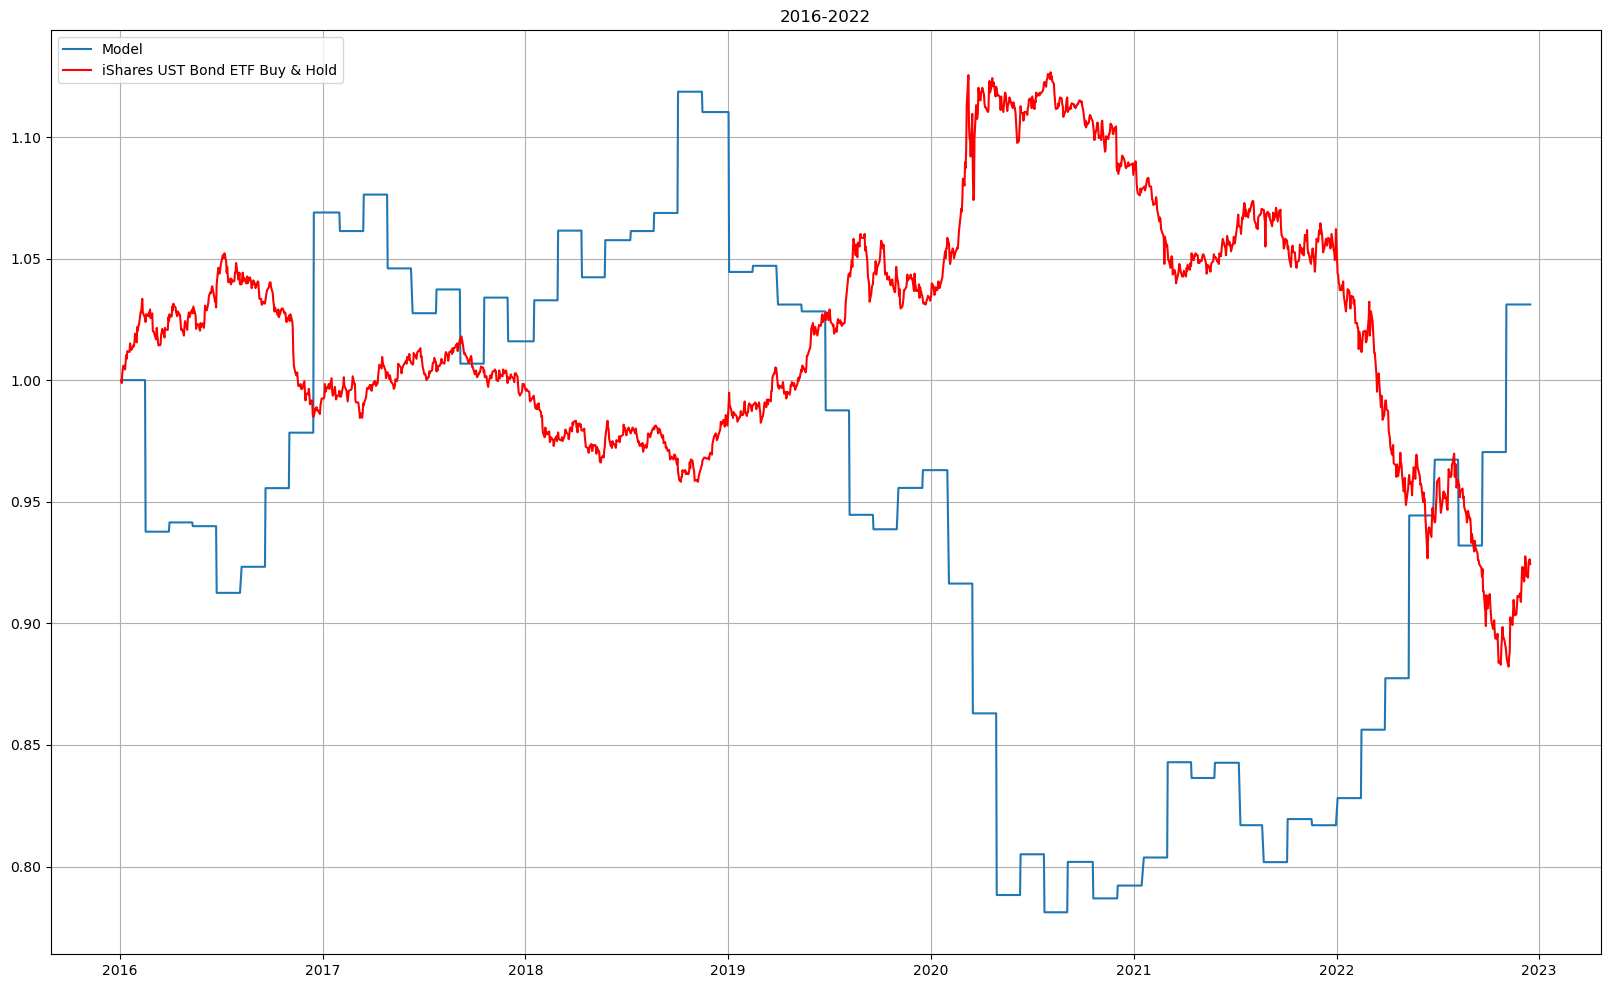

In [97]:
plot_returns(ust_index, strategies, '2016-2022')

In [98]:
def plot_positions(strategies):
    fig, ax = plt.subplots(4, 1, figsize=(20, 12))
    ax[0].plot(strategies.index, strategies.signal)
    ax[0].set_title('true signal')
    ax[1].plot(strategies.index, strategies.position)
    ax[1].set_title('position')
    ax[2].plot(strategies.index, strategies['20 Yr'])
    ax[2].set_title('20Y yield')
    ax[3].plot(test.index, test['fed regime'])
    ax[3].set_title('fed regime')

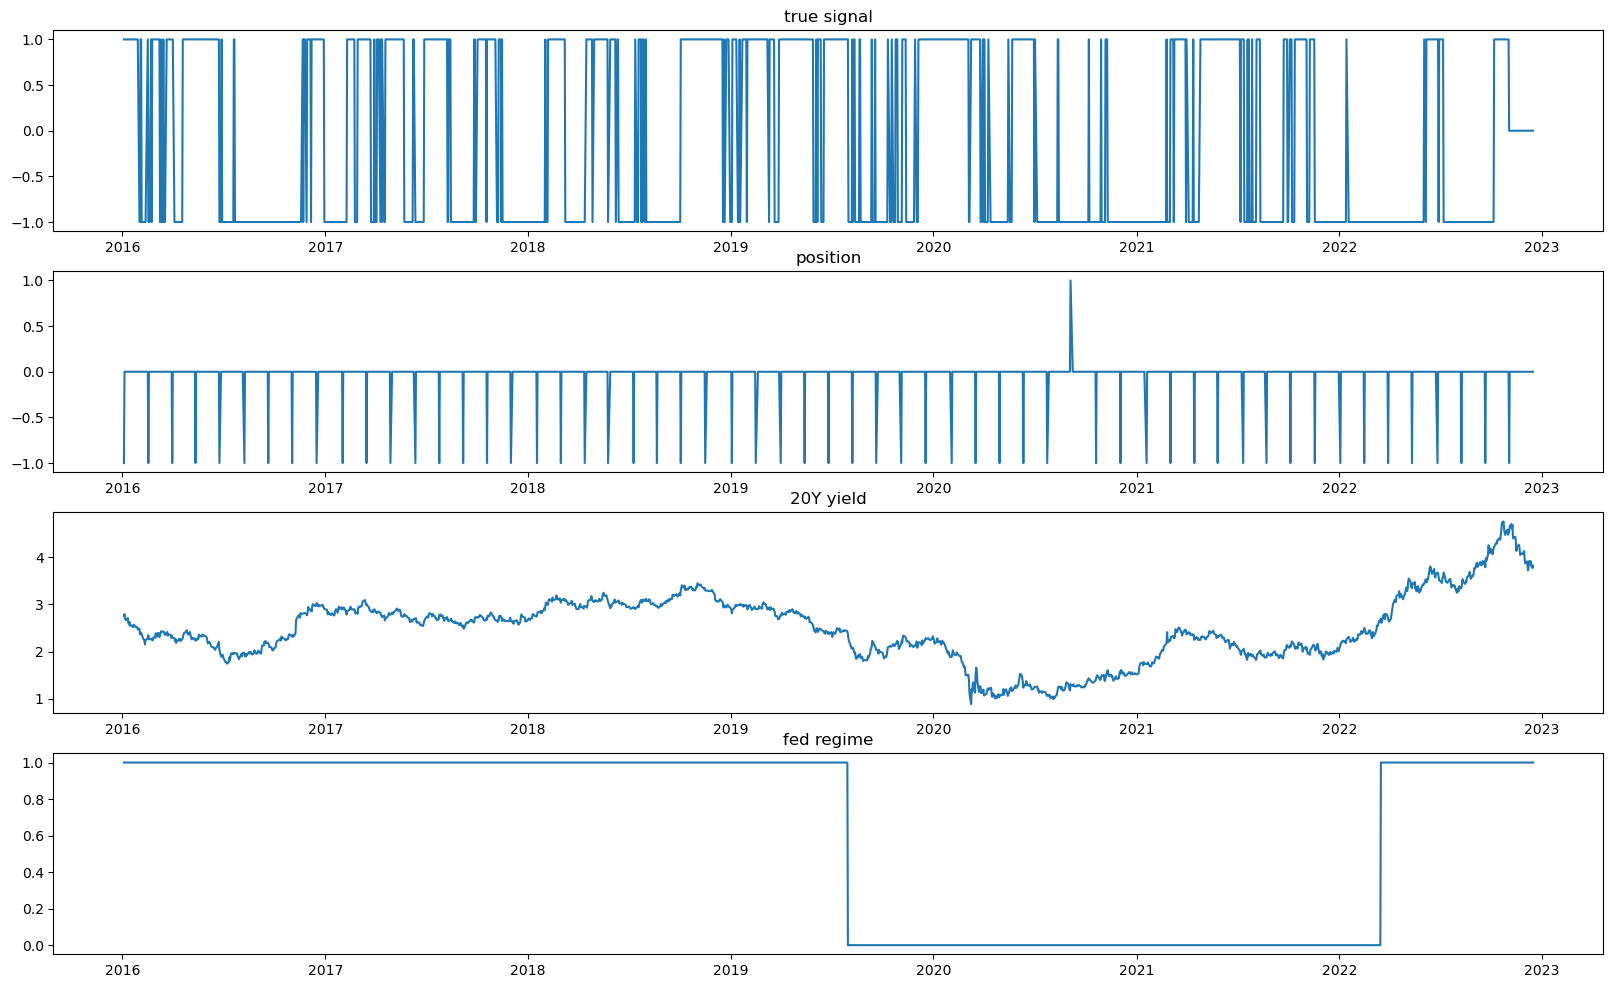

In [99]:
plot_positions(strategies)

In [100]:
ust_index_weekly = ust_index.loc[ust_index.index < '2021-01-01', :].fillna(0)
ust_index_weekly['Close shifted'] = ust_index_weekly.Close.shift(-period+1)
ust_index_weekly['Target'] = ((ust_index_weekly['Close shifted']-ust_index_weekly.Open)/ust_index_weekly.Open).shift(-1)
ust_index_weekly_return = []
for i in range(len(ust_index_weekly)):
    if i%period == 0:
        ust_index_weekly_return.append(ust_index_weekly.iloc[i]['Target'])
    else:
        ust_index_weekly_return.append(0)
temp_df = pd.DataFrame({'return': ust_index_weekly_return}).shift(period)
temp_df =  temp_df.loc[temp_df['return'] != 0, 'return'].dropna()
ust_index_sharpe = temp_df.mean()/temp_df.std()
ust_index_sharpe

0.11306818839273514

In [101]:
strategy_weekly_return = strategies.loc[(strategies.index < '2021-01-01') & (strategies['return'] != 1), 'return'] - 1
strategy_sharpe = strategy_weekly_return.mean()/strategy_weekly_return.std()
strategy_sharpe

-0.15311104926292363

In [102]:
ust_index_weekly = ust_index.fillna(0)
ust_index_weekly['Close shifted'] = ust_index_weekly.Close.shift(-period+1)
ust_index_weekly['Target'] = ((ust_index_weekly['Close shifted']-ust_index_weekly.Open)/ust_index_weekly.Open).shift(-1)
ust_index_weekly_return = []
for i in range(len(ust_index_weekly)):
    if i%period == 0:
        ust_index_weekly_return.append(ust_index_weekly.iloc[i]['Target'])
    else:
        ust_index_weekly_return.append(0)
temp_df = pd.DataFrame({'return': ust_index_weekly_return}).shift(period)
temp_df =  temp_df.loc[temp_df['return'] != 0, 'return'].dropna()
ust_index_sharpe = temp_df.mean()/temp_df.std()
ust_index_sharpe

-0.10218353189515132

In [103]:
strategy_weekly_return = strategies.loc[strategies['return'] != 1, 'return'] - 1
strategy_sharpe = strategy_weekly_return.mean()/strategy_weekly_return.std()
strategy_sharpe

0.03252281530674112